In [1]:
#!pip install nibabel
import nibabel as nib

# Load the dataset
img = nib.load(r"C:\Users\Aana\OneDrive\Desktop\College Stuff\Machine Intelligence for Medical Image Analysis\Project\mni_PD25_20170213_nifti_dataset\PD25-atlas-mask-0.5mm.nii.gz")
mask = nib.load(r"C:\Users\Aana\OneDrive\Desktop\College Stuff\Machine Intelligence for Medical Image Analysis\Project\mni_PD25_20170213_nifti_dataset\PD25-atlas-mask-0.5mm.nii.gz")

# Get the data as numpy arrays
img_data = img.get_fdata()
mask_data = mask.get_fdata()

In [2]:
img_data

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0.

In [3]:
img_data.shape

(394, 466, 378)

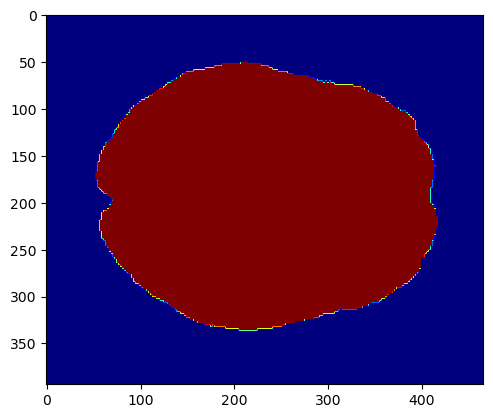

In [4]:
# Display the NumPy array as an image
import matplotlib.pyplot as plt
imageshow = img_data[:, :, 157]
plt.imshow(imageshow, cmap='jet')
plt.show()

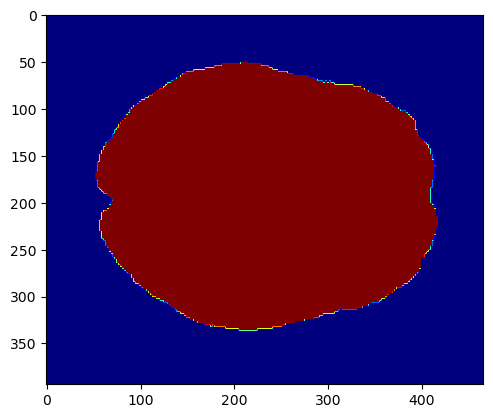

In [5]:
maskshow = mask_data[:, :, 157]
plt.imshow(maskshow, cmap='jet')
plt.show()

In [6]:
import numpy as np
import pandas as pd
import nibabel as nib
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D, concatenate, BatchNormalization, Activation, SpatialDropout3D, Conv3DTranspose
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from skimage import morphology, measure
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [7]:
# Define the dice coefficient metric
import tensorflow.keras.backend as K
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice
# Define the dice coefficient loss function
def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [8]:
# Define modified 3D U-Net architecture
input_shape=(128, 128, 64, 1)
inputs = Input(input_shape)
print(inputs.shape)
conv1 = Conv3D(64, (3, 3, 3), padding='same')(inputs)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
conv1 = Conv3D(64, (3, 3, 3), padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
conv1 = Activation('relu')(conv1)
pool1 = MaxPooling3D(pool_size=(2, 2, 2))(conv1)

conv2 = Conv3D(128, (3, 3, 3), padding='same')(pool1)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
conv2 = Conv3D(128, (3, 3, 3), padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
conv2 = Activation('relu')(conv2)
pool2 = MaxPooling3D(pool_size=(2, 2, 2))(conv2)

conv3 = Conv3D(256, (3, 3, 3), padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
conv3 = Conv3D(256, (3, 3, 3), padding='same')(conv3)
conv3 = BatchNormalization()(conv3)
conv3 = Activation('relu')(conv3)
pool3 = MaxPooling3D(pool_size=(2, 2, 2))(conv3)

conv4 = Conv3D(512, (3, 3, 3), padding='same')(pool3)
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)
conv4 = Conv3D(512, (3, 3, 3), padding='same')(conv4)
conv4 = BatchNormalization()(conv4)
conv4 = Activation('relu')(conv4)
drop4 = SpatialDropout3D(0.5)(conv4)
pool4 = MaxPooling3D(pool_size=(2, 2, 2))(drop4)

conv5 = Conv3D(1024, (3, 3, 3), padding='same')(pool4)
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)
conv5 = Conv3D(1024, (3, 3, 3), padding='same')(conv5)
conv5 = BatchNormalization()(conv5)
conv5 = Activation('relu')(conv5)
drop5 = SpatialDropout3D(0.5)(conv5)

up6 = Conv3DTranspose(512, (2, 2, 2), strides=(2, 2, 2), padding='same')(drop5)
up6 = concatenate([up6, drop4])
conv6 = Conv3D(512, (3, 3, 3), padding='same')(up6)
conv6 = BatchNormalization()(conv6)
conv6 = Activation('relu')(conv6)
conv6 = Conv3D(512, (3, 3, 3), padding='same')(conv6)
conv6 = BatchNormalization()(conv6)
conv6 = Activation('relu')(conv6)

up7 = Conv3DTranspose(256, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv6)
up7 = concatenate([up7, conv3])
conv7 = Conv3D(256, (3, 3, 3), padding='same')(up7)
conv7 = BatchNormalization()(conv7)
conv7 = Activation('relu')(conv7)
conv7 = Conv3D(256, (3, 3, 3), padding='same')(conv7)
conv7 = BatchNormalization()(conv7)
conv7 = Activation('relu')(conv7)

up8 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv7)
up8 = concatenate([up8, conv2])
conv8 = Conv3D(128, (3, 3, 3), padding='same')(up8)
conv8 = BatchNormalization()(conv8)
conv8 = Activation('relu')(conv8)
conv8 = Conv3D(128, (3, 3, 3), padding='same')(conv8)
conv8 = BatchNormalization()(conv8)
conv8 = Activation('relu')(conv8)

up9 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(conv8)
merge9 = concatenate([conv1, up9], axis=4)
conv9 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(merge9)
conv9 = Conv3D(64, (3, 3, 3), activation='relu', padding='same')(conv9)

# Apply the final convolution layer
conv10 = Conv3D(1, (1, 1, 1), activation='sigmoid')(conv9)

# Define the model
model = Model(inputs=[inputs], outputs=[conv10])

# Compile the model
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss, metrics=[dice_coef])
model.summary()

(None, 128, 128, 64, 1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 6  0           []                               
                                4, 1)]                                                            
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                , 64)                                                             
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv3d[0][0]']                 
 alization)                     , 64)                                                         

In [9]:
#pre-processing
import SimpleITK as sitk

# Read the image
image_path = r"C:\Users\Aana\OneDrive\Desktop\College Stuff\Machine Intelligence for Medical Image Analysis\Project\mni_PD25_20170213_nifti_dataset\PD25-atlas-mask-0.5mm.nii.gz"
mask_path = r"C:\Users\Aana\OneDrive\Desktop\College Stuff\Machine Intelligence for Medical Image Analysis\Project\mni_PD25_20170213_nifti_dataset\PD25-atlas-mask-0.5mm.nii.gz"
image = sitk.ReadImage(image_path)
mask = sitk.ReadImage(mask_path)

# Perform rescaling to [0, 1] range
rescaler = sitk.RescaleIntensityImageFilter()
rescaler.SetOutputMinimum(0)
rescaler.SetOutputMaximum(1)
rescaled_image = rescaler.Execute(image)

rescaled_image

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000002117934D2F0> >

In [10]:
# Apply Gaussian smoothing to reduce noise and enhance edges
smoothing_filter = sitk.SmoothingRecursiveGaussianImageFilter()
smoothing_filter.SetSigma(1.0)
smoothed_image = smoothing_filter.Execute(rescaled_image)
rescaled_image

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000002117934D2F0> >

In [11]:
# Apply N4 bias correction
corrected_image = sitk.N4BiasFieldCorrection(smoothed_image)
mask = sitk.N4BiasFieldCorrection(mask)
corrected_image

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000002110D6847B0> >

In [12]:
# Apply Otsu thresholding to binarize the mask
threshold_filter = sitk.OtsuThresholdImageFilter()
threshold_filter.SetInsideValue(0)
threshold_filter.SetOutsideValue(1)
mask = threshold_filter.Execute(mask)
mask

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000002110D687660> >

In [13]:
# Apply binary hole filling to remove small holes in mask
hole_filling_filter = sitk.BinaryFillholeImageFilter()
hole_filling_filter.SetForegroundValue(1)
mask = hole_filling_filter.Execute(mask)
mask

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000002110DF108D0> >

In [14]:
# Apply binary closing to smooth the edges  of mask
closing_filter = sitk.BinaryMorphologicalClosingImageFilter()
closing_filter.SetKernelType(sitk.sitkBall)
closing_filter.SetKernelRadius(1)
mask = closing_filter.Execute(mask)
mask

<SimpleITK.SimpleITK.Image; proxy of <Swig Object of type 'std::vector< itk::simple::Image >::value_type *' at 0x000002110DF1BAB0> >

In [15]:
# Convert the SimpleITK image to NumPy array for further processing
input_image = sitk.GetArrayFromImage(corrected_image)
mask = sitk.GetArrayFromImage(mask)
input_image.shape

(378, 466, 394)

In [16]:
mask.shape

(378, 466, 394)

In [17]:
# Reshape the array 
from skimage.transform import resize

# assuming `input_image` is the array of shape (378, 466, 394)
resized_image = resize(input_image, (128,128,128, 64, 1), anti_aliasing=True)

# check the shape of the resized image
print(resized_image.shape)

(128, 128, 128, 64, 1)


In [18]:
# Reshape the array 
# assuming `input_image` is the array of shape (378, 466, 394)
resized_mask = resize(mask, (128,128,128, 64, 1), anti_aliasing=True)

# check the shape of the resized image
print(resized_mask.shape)

(128, 128, 128, 64, 1)


In [19]:
# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(resized_image, resized_mask, test_size=0.2, train_size=0.8, random_state=42)

In [20]:
X_train.shape

(102, 128, 128, 64, 1)

In [ ]:
# set the number of epochs and batch size
epochs = 20
batch_size = 8

# X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2], 1))
# X_train_new_shape = np.expand_dims(X_train, axis=-1)

# y_train = np.reshape(y_train, (y_train.shape[0], y_train.shape[1], y_train.shape[2], 1))
# y_train_new_shape = np.expand_dims(y_train, axis=-1)


# fit the model on the train and validation sets
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, epochs=epochs)

# evaluate the model on the test set
test_loss, test_dice = model.evaluate(X_test, y_test, verbose=0)

# print the test loss and test dice score
print('Test loss:', test_loss)
print('Test Dice score:', test_dice)

Epoch 1/20
